In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
from sklearn.decomposition import PCA
import itertools
import matplotlib.patches as mpatches
from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import kneighbors_graph
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import SpectralClustering
import matplotlib.patches as mpatches
import umap
import bbknn
import bbknn.matrix
from importlib import reload
from scipy import stats
import scipy
import tabulate
import gget
import sys

# locals
sys.path.append("../")
import utils as ut
reload(ut)

2023-04-07 15:25:04.539734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 15:25:04.656848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-04-07 15:25:04.656871: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-07 15:25:04.683974: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-07 15:25:05.5745

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/LRAnalysis/../utils.py'>

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

done


In [3]:
data = {} # rna dict
refs = {} # label dict

keys = ['ND', 'HFD8', 'HFD14']

ctypes = [
    'Monocytes', 
    'Mac4', 
    'Mac5', 
]

for key in keys:
    rf = rna[key].copy()
    lf = labels[key]
    
    labelMask = (lf['cellType'].isin(ctypes))
    
    # add key flags to barcodes 
    mf = lf[labelMask].reset_index(drop=True)
    mf['cellId'] = mf['cellId'] + "_" + key
    
    rf.index = rf.index + "_" + key
    
    # filter out non-myleiod cells
    rf = rf[rf.index.isin(mf['cellId'])]
    rf = ut.normalize(rf, 1e6)
    
    data[key] = rf
    refs[key] = mf.drop_duplicates(subset='cellId')
    
    print(key, mf.shape, rf.shape)

    
print('done')

ND (195, 6) (194, 31053)
HFD8 (1665, 6) (1660, 31053)
HFD14 (4300, 6) (4290, 31053)
done


In [4]:
# break

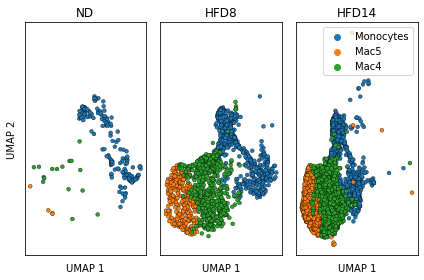

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 14, 5
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()

keys = ['ND', 'HFD8', 'HFD14']
for i, key in enumerate(keys):
    rf = data[key]
    lf = refs[key]
    
    sns.scatterplot(data=lf.sort_values(by='cellType', ascending=False), 
                    x='x',
                    y='y', 
                    hue='cellType', 
                    ec='k', 
                    s=15, 
                    ax=axs[i])
    if i == 2:
        axs[i].legend(loc='upper right')
    else:
        axs[i].legend().remove()
        
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_ylabel("UMAP 2")
    axs[i].set_xlabel("UMAP 1")
    axs[i].set_title(key)
    
plt.tight_layout()

In [6]:
# break

In [7]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath, engine="openpyxl")
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


,Pair.Name,Ligand.Mouse,Receptor.Mouse,Source,ManualAnnotation,Ligand.CC,Ligand.GO,Reference (PMID / KEGG),ligand,receptor
0,A2m-Lrp1,A2m,Lrp1,Ramilowski,Correct,Secreted,Other,"1702392,10652313, 12194978",A2M,LRP1
1,Adgre5-Cd55,Adgre5,Cd55,Baccin,Correct,Membrane,Other,23447688,ADGRE5,CD55
2,Adipoq-Adipor1,Adipoq,Adipor1,Ramilowski,Correct,Secreted,Other,12802337,ADIPOQ,ADIPOR1
3,Adipoq-Adipor2,Adipoq,Adipor2,Ramilowski,Correct,Secreted,Other,"12802337, 12802330",ADIPOQ,ADIPOR2
4,Adm-Calcrl&Ramp2,Adm,Calcrl&Ramp2,Baccin,Correct,Secreted,Other,10342881,ADM,CALCRL&RAMP2


In [8]:
"""GLOBAL DEG """
allLR = list(set(lr['ligand'].to_list() + lr['receptor'].to_list()))
print(f"{len(allLR)=}")


cf = []
xf = []

for i, key in enumerate(keys):
    
    cf.append(data[key])
    xf.append(refs[key])
    
cf = pd.concat(cf)    
xf = pd.concat(xf)    

print(f"{cf.shape=} {xf.shape=}")

# get expressed LR 
expLR = [x for x in allLR if x in rf.columns]
print(f"{len(expLR)=}")


res = []    
for ctype in ctypes:
    cellIds = xf[xf['cellType'] == ctype]['cellId'].to_list()
    
    mask = cf.index.isin(cellIds)
    ingroup = cf[mask]
    outgroup = cf[~mask]
    
    for gene in expLR:
        score, pval = scipy.stats.ranksums(ingroup[gene], 
                                           outgroup[gene],
                                           alternative='two-sided')
        
        inMean = ingroup[gene].mean()
        outMean = outgroup[gene].mean()
        lfc = np.log2(inMean) - np.log2(outMean)
        
        row = {
            'gene' : gene,
            'cellType' : ctype,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'groupMean' : inMean,
            'otherMean' : outMean,
        }
        res.append(row)
        
res = pd.DataFrame(res)
print(f"{res.shape=}")
res.head()

len(allLR)=1214
cf.shape=(6144, 31053) xf.shape=(6144, 6)
len(expLR)=1148


/tmp/ipykernel_2353367/1063136462.py:39: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2(inMean) - np.log2(outMean)
/tmp/ipykernel_2353367/1063136462.py:39: RuntimeWarning: invalid value encountered in double_scalars
  lfc = np.log2(inMean) - np.log2(outMean)


res.shape=(3444, 7)


,gene,cellType,score,pval,log2foldchange,groupMean,otherMean
0,TNFSF9,Monocytes,4.084500,4.417190e-05,2.176334,123.547350,27.333271
1,FGF22,Monocytes,0.000000,1.000000e+00,NaN,0.000000,0.000000
2,NPW,Monocytes,0.000000,1.000000e+00,NaN,0.000000,0.000000
3,PLXNB2,Monocytes,-11.202229,3.975999e-29,0.138038,174.153978,158.263114
4,OPRM1,Monocytes,0.000000,1.000000e+00,NaN,0.000000,0.000000


In [9]:
def printGSR(ef, top=None, columns=['path_name', 'p_val', 'overlapping_genes']):
    """A function to print pathway results """
    n = top
    if top is None:
        n = len(ef)

    ef['overlapping_genes'] = ef['overlapping_genes'].apply(lambda x: ", ".join(x))
    printDf = ef[columns].head(n)
    print(tabulate.tabulate(printDf, 
                            headers=columns, 
                            showindex=False,
                            tablefmt='orgtbl'))

Fri Apr  7 15:29:49 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


(573, 8)
       cellType geneName  log2foldchange
1041  Monocytes    Cd177        5.899031
621   Monocytes      Ace        5.247759
494   Monocytes     Vcan        4.624274
182   Monocytes     Il1b        4.575311
1116  Monocytes    Thbs1        4.410096
341   Monocytes     Slpi        4.392617
941   Monocytes    Cd244        3.751929
227   Monocytes       C3        3.717928
554   Monocytes     Sell        3.554372
197   Monocytes   Cx3cr1        3.238104
844   Monocytes   Il17ra        3.226680
414   Monocytes    Csf3r        3.201232
284   Monocytes    Ptgs2        3.130718
339   Monocytes  Ceacam1        2.938137
419   Monocytes    Sorl1        2.809757
321   Monocytes  Il13ra1        2.711755
577   Monocytes     Ccr2        2.696453
201   Monocytes      Osm        2.665060
989   Monocytes   Sema4a        2.399498
743   Monocytes      Spn        2.302033
1019  Monocytes    Cxcr4        2.245032
0     Monocytes   Tnfsf9        2.176334
498   Monocytes   Cxcl10        2.123493
872   M

Fri Apr  7 15:29:49 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                                         |       p_val | overlapping_genes                                                                   |
|-----------------------------------------------------------------------------------+-------------+-------------------------------------------------------------------------------------|
| cytokine-mediated signaling pathway (GO:0019221)                                  | 2.59819e-12 | CXCL10, CEACAM1, CSF3R, IL1B, CCL4, OSM, TNFSF9, CCL2, PTGS2, CCR2, IL17RA, IL13RA1 |
| cellular response to cytokine stimulus (GO:0071345)                               | 1.42361e-10 | CXCL10, CSF3R, IL1B, CCL4, OSM, CXCR4, CCL2, PTGS2, CCR2, IL13RA1                   |
| positive regulation of cytokine production (GO:0001819)                           | 4.80979e-09 | C3, IL1B, OSM, PTGS2, SORL1, CD244, CCR2, IL17RA                                    |
| inflammatory response (GO:0006954)                                  

Fri Apr  7 15:29:50 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                                   |       p_val | overlapping_genes                                   |
|-----------------------------------------------------------------------------+-------------+-----------------------------------------------------|
| regulation of complement activation (GO:0030449)                            | 3.05589e-11 | C1QB, C1QA, CFH, CD81, C5AR1, C3AR1                 |
| regulation of immune effector process (GO:0002697)                          | 4.40413e-11 | C1QB, C1QA, CFH, CD81, C5AR1, C3AR1                 |
| regulation of humoral immune response (GO:0002920)                          | 4.95061e-11 | C1QB, C1QA, CFH, CD81, C5AR1, C3AR1                 |
| positive regulation of cell population proliferation (GO:0008284)           | 7.12041e-08 | CD74, CSF1R, CD81, C5AR1, LIFR, IGF1, GAS6, TGFBR2  |
| humoral immune response mediated by circulating immunoglobulin (GO:0002455) | 2.82763e-07 | C1QB, C1QA, CD81  

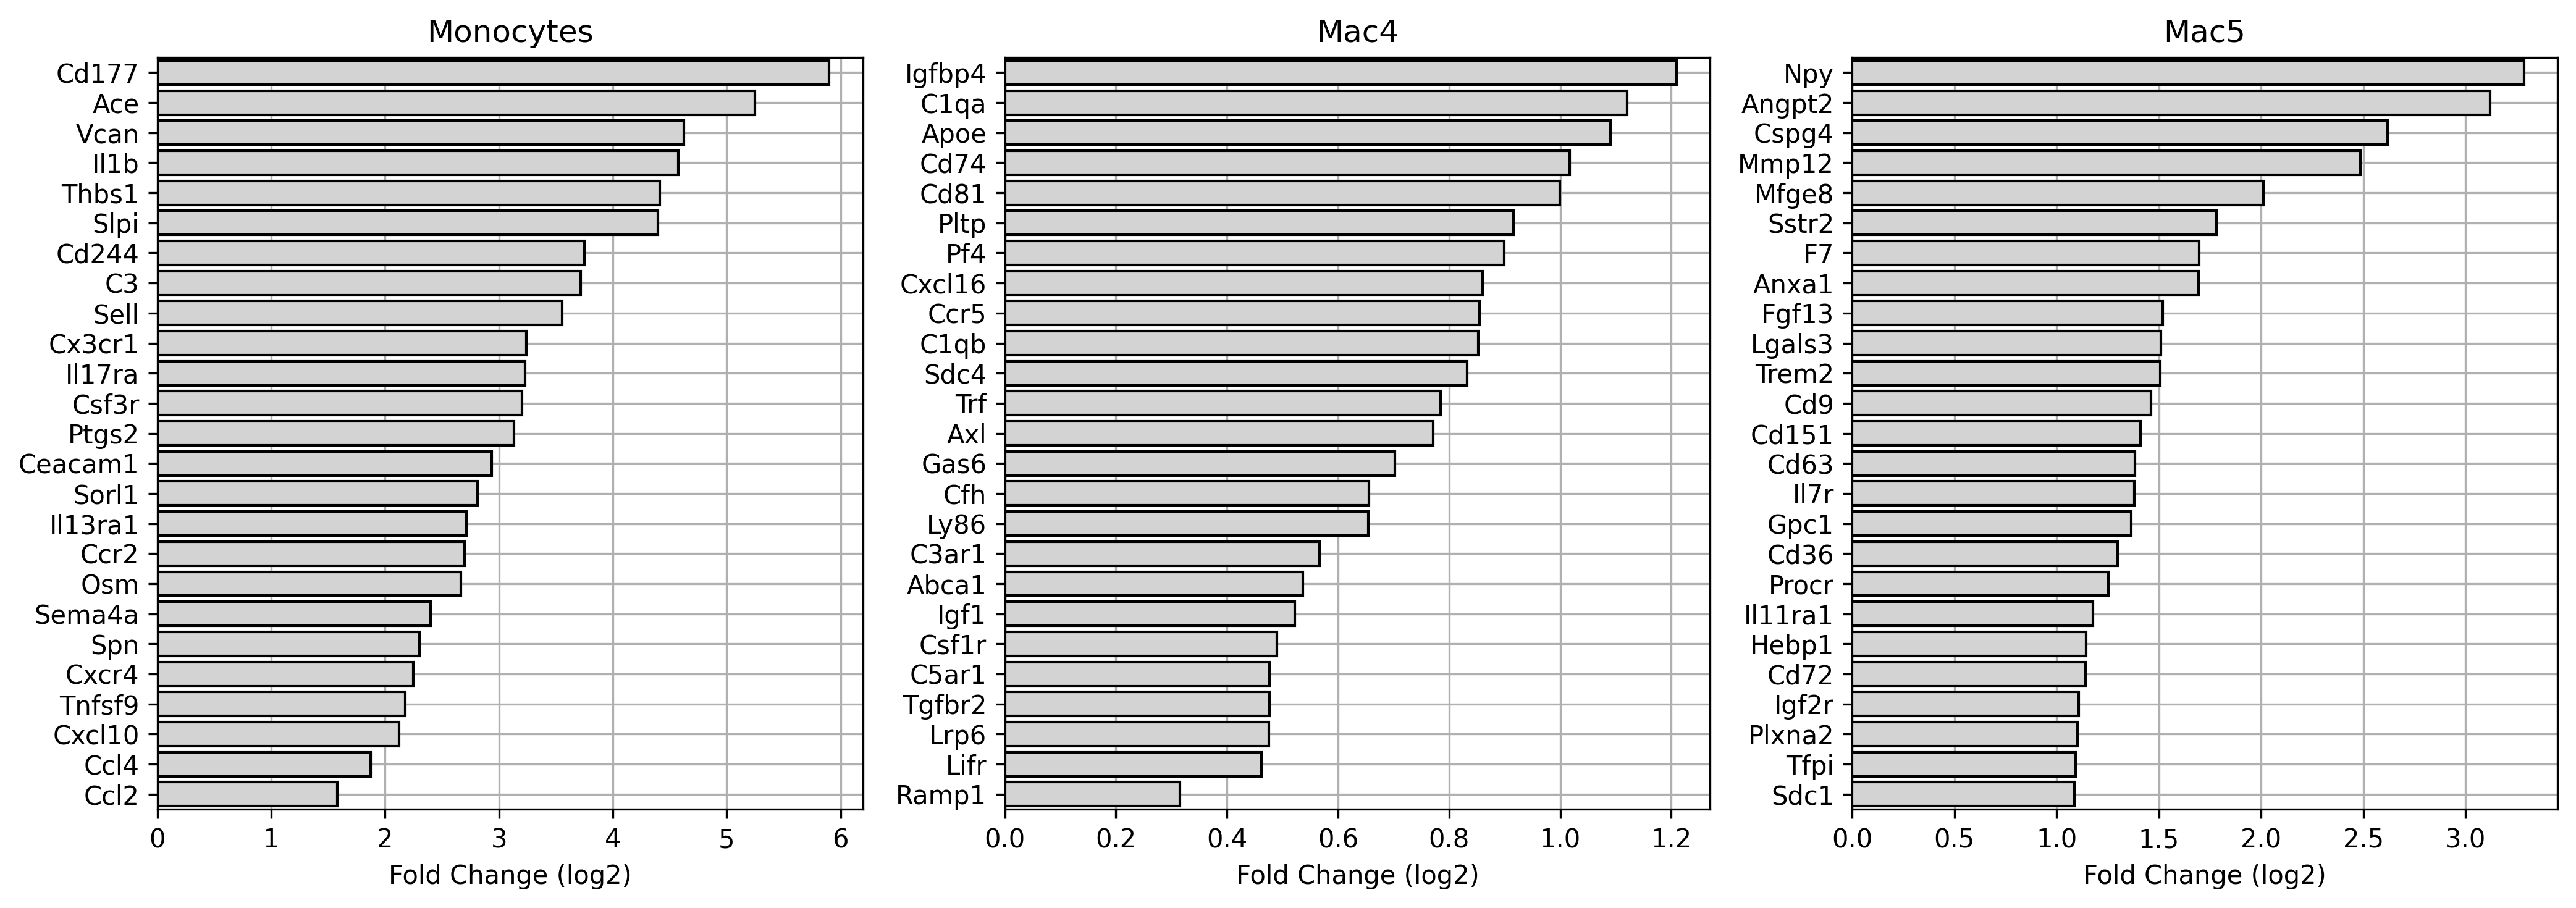

In [10]:
alpha = 0.01
top = 25

sig = res[res['pval'] < alpha]
sig = sig.sort_values(by=['cellType', 'log2foldchange'], ascending=[True, False])
sig['geneName'] = sig['gene'].apply(lambda x: str(x).lower().capitalize())
print(sig.shape)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 14, 5
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()


for i, ctype in enumerate(ctypes):
    
    tf = sig[sig['cellType'] == ctype]
    # tf = pd.concat([tf.head(top), tf.tail(top)])
    
    sns.barplot(data=tf.head(top),
                y='geneName', 
                x='log2foldchange',
                ec='k', 
                color='lightgrey',
                zorder=10,
                ax=axs[i])
    
    axs[i].grid(True, zorder=-1)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('Fold Change (log2)')
    axs[i].set_title(ctype)
    print(tf[['cellType', 'geneName', 'log2foldchange']].head(top))
    print()
    
    genes = tf['gene'].head(top).to_list()
    
    # db = 'WikiPathways_2019_Mouse'
    # db = 'KEGG_2019_Mouse'
    db = 'ontology'
    enrich = gget.enrichr(genes, database=db)
    printGSR(enrich, top=20)
    
    
plt.tight_layout()


# sig.head()



In [11]:
# res.to_csv("~/temp/globalDEG.csv", index=False)
# print("done")

In [12]:
# break

In [13]:
""" Explore week 8 in-depth """
allLR = list(set(lr['ligand'].to_list() + lr['receptor'].to_list()))
print(f"{len(allLR)=}")


keys = ['HFD8']

cf = []
xf = []

for i, key in enumerate(keys):
    
    cf.append(data[key])
    xf.append(refs[key])
    
cf = pd.concat(cf)    
xf = pd.concat(xf)    

print(f"{cf.shape=} {xf.shape=}")

# get expressed LR 
expLR = [x for x in allLR if x in rf.columns]
print(f"{len(expLR)=}")


res = []    
for ctype in ctypes:
    cellIds = xf[xf['cellType'] == ctype]['cellId'].to_list()
    
    mask = cf.index.isin(cellIds)
    ingroup = cf[mask]
    outgroup = cf[~mask]
    
    for gene in expLR:
        score, pval = scipy.stats.ranksums(ingroup[gene], 
                                           outgroup[gene],
                                           alternative='two-sided')
        
        inMean = ingroup[gene].mean()
        outMean = outgroup[gene].mean()
        lfc = np.log2(inMean) - np.log2(outMean)
        
        row = {
            'gene' : gene,
            'cellType' : ctype,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'groupMean' : inMean,
            'otherMean' : outMean,
        }
        res.append(row)
        
res = pd.DataFrame(res)
print(f"{res.shape=}")
res.head()


len(allLR)=1214
cf.shape=(1660, 31053) xf.shape=(1660, 6)
len(expLR)=1148


/tmp/ipykernel_2353367/2336745871.py:41: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2(inMean) - np.log2(outMean)
/tmp/ipykernel_2353367/2336745871.py:41: RuntimeWarning: invalid value encountered in double_scalars
  lfc = np.log2(inMean) - np.log2(outMean)


res.shape=(3444, 7)


,gene,cellType,score,pval,log2foldchange,groupMean,otherMean
0,TNFSF9,Monocytes,0.151771,8.793674e-01,1.124474,128.892460,59.118984
1,FGF22,Monocytes,0.000000,1.000000e+00,NaN,0.000000,0.000000
2,NPW,Monocytes,0.000000,1.000000e+00,NaN,0.000000,0.000000
3,PLXNB2,Monocytes,-5.653954,1.567983e-08,0.043175,185.622227,180.149431
4,OPRM1,Monocytes,0.000000,1.000000e+00,NaN,0.000000,0.000000


Fri Apr  7 15:30:10 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


(475, 8)
       cellType geneName  log2foldchange
1041  Monocytes    Cd177        5.275044
621   Monocytes      Ace        5.135663
341   Monocytes     Slpi        4.930791
182   Monocytes     Il1b        4.597229
941   Monocytes    Cd244        4.074525
1116  Monocytes    Thbs1        4.050083
227   Monocytes       C3        3.742276
197   Monocytes   Cx3cr1        3.535182
339   Monocytes  Ceacam1        3.531619
844   Monocytes   Il17ra        3.266348
321   Monocytes  Il13ra1        2.905058
419   Monocytes    Sorl1        2.657963
743   Monocytes      Spn        2.612349
201   Monocytes      Osm        2.317168
284   Monocytes    Ptgs2        2.308486
577   Monocytes     Ccr2        2.014962
1019  Monocytes    Cxcr4        1.986005
989   Monocytes   Sema4a        1.814513
27    Monocytes   Adgre5        1.768448
715   Monocytes     Ccl3        1.619245
1032  Monocytes    Ptprc        1.549035
839   Monocytes    Il6ra        1.533244
759   Monocytes   Il10ra        1.436974
872   M

Fri Apr  7 15:30:11 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                                                 |       p_val | overlapping_genes                                                          |
|-------------------------------------------------------------------------------------------+-------------+----------------------------------------------------------------------------|
| positive regulation of cytokine production (GO:0001819)                                   | 3.97667e-12 | CD86, C3, PTPRC, IL1B, OSM, PTGS2, SORL1, CD244, CCR2, IL17RA              |
| cytokine-mediated signaling pathway (GO:0019221)                                          | 7.10933e-11 | CD86, CEACAM1, IL10RA, IL1B, CCL4, OSM, CCL3, PTGS2, CCR2, IL17RA, IL13RA1 |
| cellular response to cytokine stimulus (GO:0071345)                                       | 1.42361e-10 | CD86, IL10RA, IL1B, CCL4, OSM, CCL3, CXCR4, PTGS2, CCR2, IL13RA1           |
| positive regulation of tumor necrosis factor superfamily cytokine product

Fri Apr  7 15:30:11 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                                   |       p_val | overlapping_genes                                     |
|-----------------------------------------------------------------------------+-------------+-------------------------------------------------------|
| inflammatory response (GO:0006954)                                          | 2.47458e-10 | CCL24, CCL7, C5AR1, C3AR1, CXCL1, CCR5, CXCL2, PF4    |
| cellular response to cytokine stimulus (GO:0071345)                         | 3.69082e-09 | CCL24, CCL7, AXL, SDC1, CXCL1, GAS6, CCR5, CXCL2, PF4 |
| regulation of complement activation (GO:0030449)                            | 4.06714e-09 | C1QB, C1QA, CD81, C5AR1, C3AR1                        |
| regulation of immune effector process (GO:0002697)                          | 5.49485e-09 | C1QB, C1QA, CD81, C5AR1, C3AR1                        |
| regulation of humoral immune response (GO:0002920)                          | 6.05051e-09 | C1QB, 

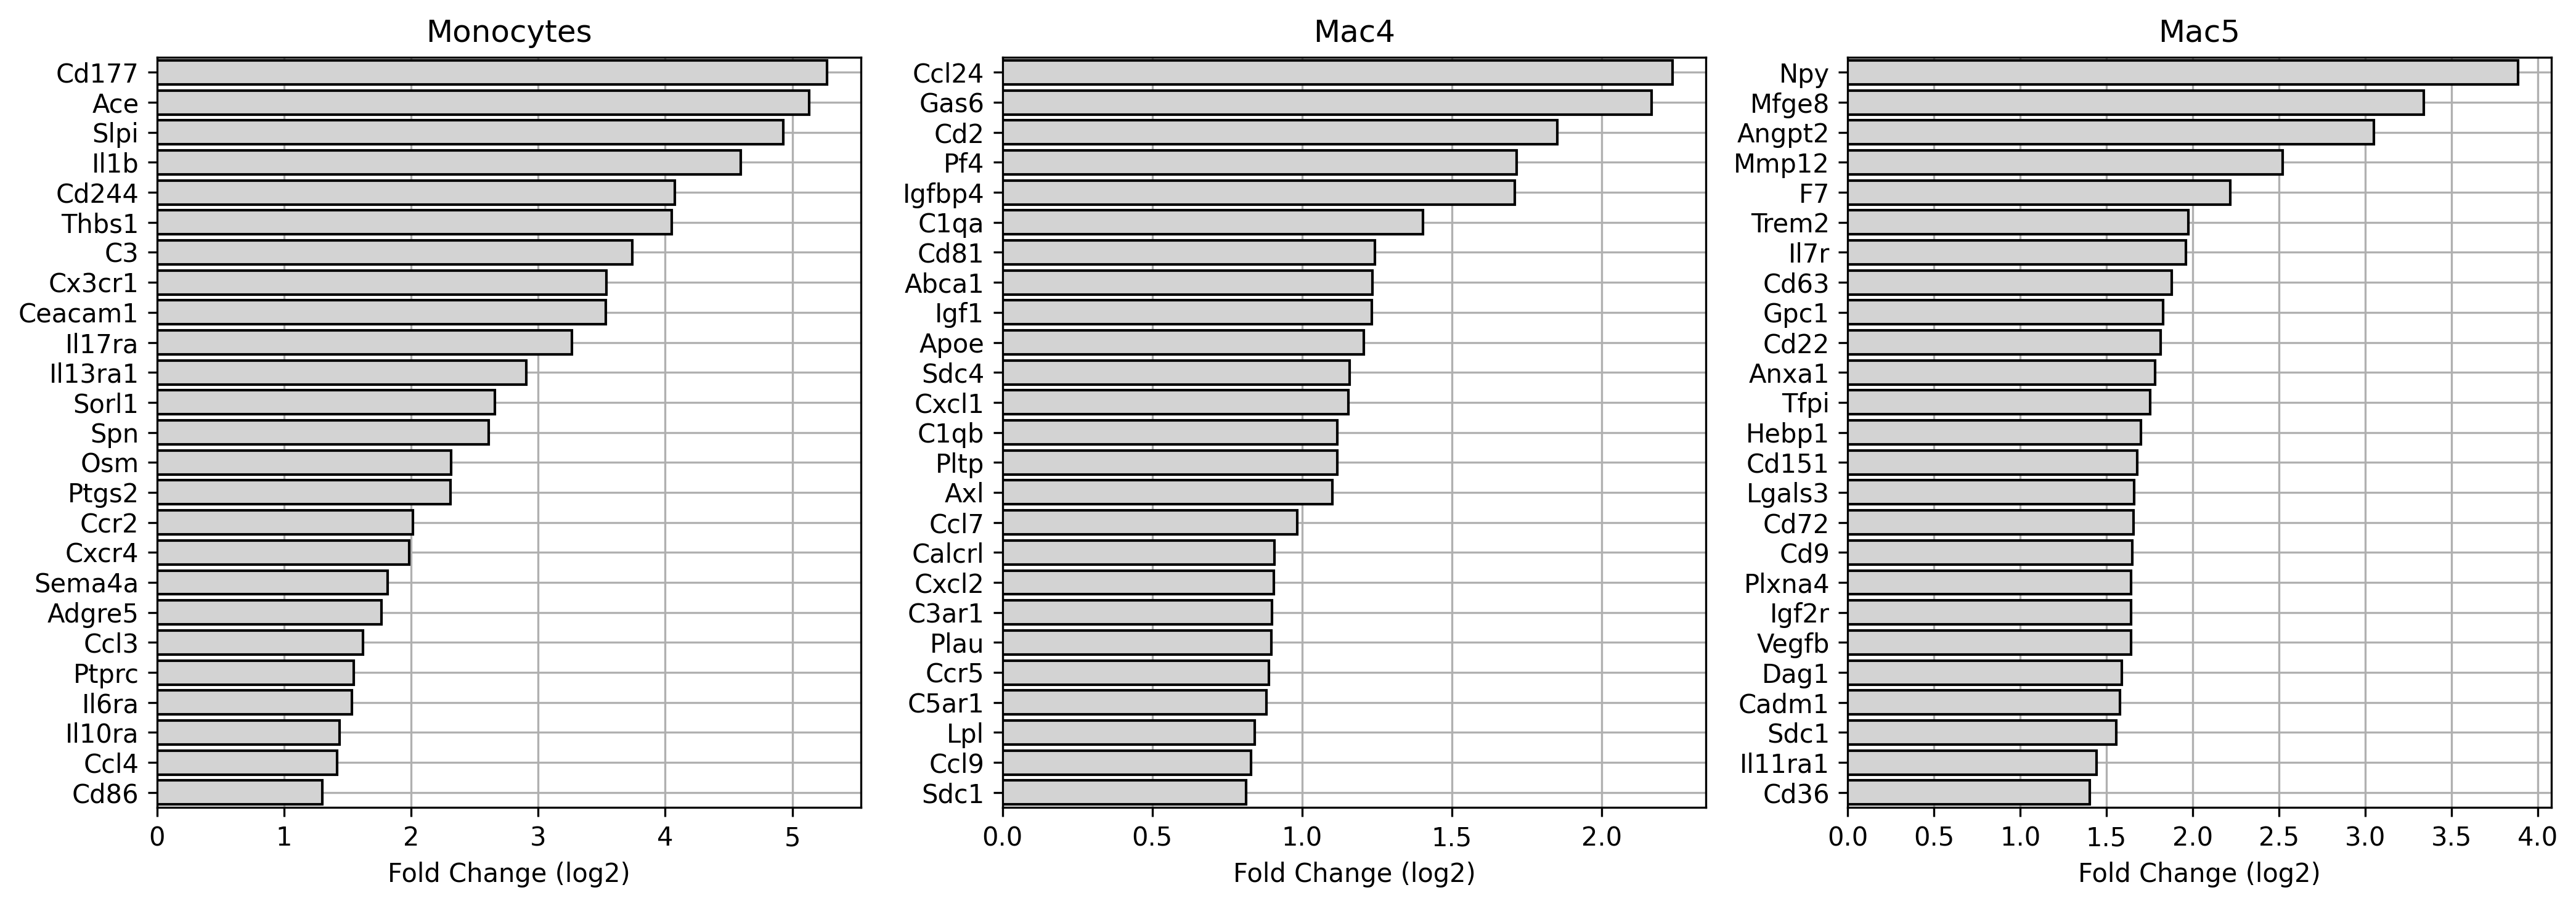

In [14]:
alpha = 0.01
top = 25

sig = res[res['pval'] < alpha]
sig = sig.sort_values(by=['cellType', 'log2foldchange'], ascending=[True, False])
sig['geneName'] = sig['gene'].apply(lambda x: str(x).lower().capitalize())
print(sig.shape)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 14, 5
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()


for i, ctype in enumerate(ctypes):
    
    tf = sig[sig['cellType'] == ctype]
    # tf = pd.concat([tf.head(top), tf.tail(top)])
    
    sns.barplot(data=tf.head(top),
                y='geneName', 
                x='log2foldchange',
                ec='k', 
                color='lightgrey',
                zorder=10,
                ax=axs[i])
    
    axs[i].grid(True, zorder=-1)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('Fold Change (log2)')
    axs[i].set_title(ctype)
    print(tf[['cellType', 'geneName', 'log2foldchange']].head(top))
    print()
    
    genes = tf['gene'].head(top).to_list()
    
    # db = 'WikiPathways_2019_Mouse'
    # db = 'KEGG_2019_Mouse'
    db = 'ontology'
    enrich = gget.enrichr(genes, database=db)
    printGSR(enrich, top=20)
    
    
plt.tight_layout()


# sig.head()



In [15]:
"""
MONOCYTES AT WEEK 8 VS ND
"""

'\nMONOCYTES AT WEEK 8 VS ND\n'

In [16]:
""" week 8 spatial data """

cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'macrophage' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()
df.head()

df.shape=(14836, 13)
HFD8     6782
ND       4068
HFD14    3986
Name: key, dtype: int64



,spotId,Dendritic cells,Mac4,Stromal cells,NK cells,Mac2,Monocytes,T cells,Mac5,Mac3,Mac1,B cells,key
0,AAACAAGTATCTCCCA.1,0.087213,0.113186,0.270488,0.096431,0.057255,0.083130,0.047384,0.163491,0.049659,0.006606,0.025157,HFD8
1,AAACACCAATAACTGC.1,0.159247,0.129071,0.105884,0.002606,0.084753,0.088446,0.016601,0.302068,0.046115,0.038813,0.026395,HFD8
2,AAACAGCTTTCAGAAG.1,0.042437,0.128286,0.329050,0.064440,0.050805,0.049080,0.052493,0.100578,0.065773,0.025274,0.091783,HFD8
3,AAACAGGGTCTATATT.1,0.038153,0.094966,0.294255,0.055503,0.061959,0.060107,0.048176,0.127678,0.099188,0.040547,0.079468,HFD8
4,AAACAGTGTTCCTGGG.1,0.000020,0.256841,0.323585,0.003329,0.015668,0.010229,0.002518,0.222850,0.000587,0.000737,0.163636,HFD8


In [17]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

normalize = True

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "macrophage" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        if normalize:
            sdf = ut.normalize(sdf)
        spt[key] = sdf
    
print('done')

HFD8_macrophage_spt.csv
HFD14_macrophage_spt.csv
ND_macrophage_spt.csv
done


In [18]:
key = 'HFD8'
sdf = spt[key]

# get the expressed LRs
workingList = list(set(sig['gene'].to_list()))
print(f"{len(workingList)=}")

expLR = [x for x in workingList if x in sdf.columns]
print(f"{len(expLR)=}")


cardDf = df[df['key'] == key]
cardDf = cardDf.drop_duplicates()
cardDf = cardDf[cardDf['spotId'].isin(sdf.index)]
sdf = sdf[sdf.index.isin(cardDf['spotId'])]

print(f"{cardDf.shape=}")
print(f"{sdf.shape=}")
assert(np.all(sdf.index == cardDf['spotId'])) # make sure the sort order is the same
print()

res = []

for i, ctype in enumerate(ctypes):
    tf = sig[sig['cellType'] == ctype]
    
    # ligands
    gf = lr[lr['ligand'].isin(tf['gene'])]
    
    for idx, row in gf.iterrows():
        lig = row['ligand']
        rec = row['receptor']
        lfc = tf.loc[tf['gene'] == lig]['log2foldchange'].values[0]
        degpval = tf.loc[tf['gene'] == lig]['pval'].values[0]
        
        if "&" in rec or "&" in lig:
            continue
            
        if not rec in sdf.columns or lig not in sdf.columns:
            continue
        
        lrColoc = sdf[[lig, rec]].sum(axis=1)
        lrColoc = np.sum(lrColoc > 0) / len(sdf)
        lrcorr, lrpval = scipy.stats.pearsonr(sdf[lig], sdf[rec])
        
        corr, pval = scipy.stats.pearsonr(sdf[lig], cardDf[ctype])
                
        nrow = {
            'cellType' : ctype,
            'ligand' : lig,
            'receptor' : rec,
            'type' : 'ligand',
            'log2foldchange' : lfc,
            'deg_pval' : degpval,
            'LRcolocalization' : lrColoc,
            'LRcorr' : lrcorr,
            'LRpval' : lrpval,
            'corr' : corr,
            'pval' : pval,
        }
        res.append(nrow)
        
    # receptors
    gf = lr[lr['receptor'].isin(tf['gene'])]
    
    for idx, row in gf.iterrows():
        lig = row['ligand']
        rec = row['receptor']
        
        if "&" in rec or "&" in lig:
            continue
            
        if not rec in sdf.columns or lig not in sdf.columns:
            continue
        
        
        lfc = tf.loc[tf['gene'] == rec]['log2foldchange'].values[0]
        degpval = tf.loc[tf['gene'] == rec]['pval'].values[0]
        lrColoc = sdf[[lig, rec]].sum(axis=1)
        lrColoc = np.sum(lrColoc > 0) / len(sdf)

        corr, pval = scipy.stats.pearsonr(sdf[rec], cardDf[ctype])

        nrow = {
            'cellType' : ctype,
            'ligand' : lig,
            'receptor' : rec,
            'type' : 'receptor',
            'log2foldchange' : lfc,
            'deg_pval' : degpval,
            'LRcolocalization' : lrColoc,
            'corr' : corr,
            'pval' : pval,
        }
        res.append(nrow)

res = pd.DataFrame(res)
print(f"{res.shape=}")
res.head()

len(workingList)=218
len(expLR)=218
cardDf.shape=(3391, 13)
sdf.shape=(3391, 31053)



/home/cstansbu/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cstansbu/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cstansbu/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cstansbu/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/cstansbu/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: A

res.shape=(1797, 11)


,cellType,ligand,receptor,type,log2foldchange,deg_pval,LRcolocalization,LRcorr,LRpval,corr,pval
0,Monocytes,ADGRE5,CD55,ligand,1.768448,1.967056e-35,0.012386,0.017286,0.314264,-0.012271,0.475025
1,Monocytes,ALCAM,CD6,ligand,-0.131120,1.003628e-21,0.028605,-0.001969,0.908733,0.044609,0.009377
2,Monocytes,ALCAM,L1CAM,ligand,-0.131120,1.003628e-21,0.028605,-0.001969,0.908733,0.044609,0.009377
3,Monocytes,ANGPT2,TEK,ligand,-4.188579,4.194171e-04,0.003244,-0.001036,0.951895,-0.003878,0.821392
4,Monocytes,ANGPT2,TIE1,ligand,-4.188579,4.194171e-04,0.004718,-0.001143,0.946967,-0.003878,0.821392


In [19]:
# res.to_csv("~/temp/HFD8_lr_DEG.csv")

In [20]:
# break

In [21]:
pdf = res.copy()
pdf.head()

,cellType,ligand,receptor,type,log2foldchange,deg_pval,LRcolocalization,LRcorr,LRpval,corr,pval
0,Monocytes,ADGRE5,CD55,ligand,1.768448,1.967056e-35,0.012386,0.017286,0.314264,-0.012271,0.475025
1,Monocytes,ALCAM,CD6,ligand,-0.131120,1.003628e-21,0.028605,-0.001969,0.908733,0.044609,0.009377
2,Monocytes,ALCAM,L1CAM,ligand,-0.131120,1.003628e-21,0.028605,-0.001969,0.908733,0.044609,0.009377
3,Monocytes,ANGPT2,TEK,ligand,-4.188579,4.194171e-04,0.003244,-0.001036,0.951895,-0.003878,0.821392
4,Monocytes,ANGPT2,TIE1,ligand,-4.188579,4.194171e-04,0.004718,-0.001143,0.946967,-0.003878,0.821392


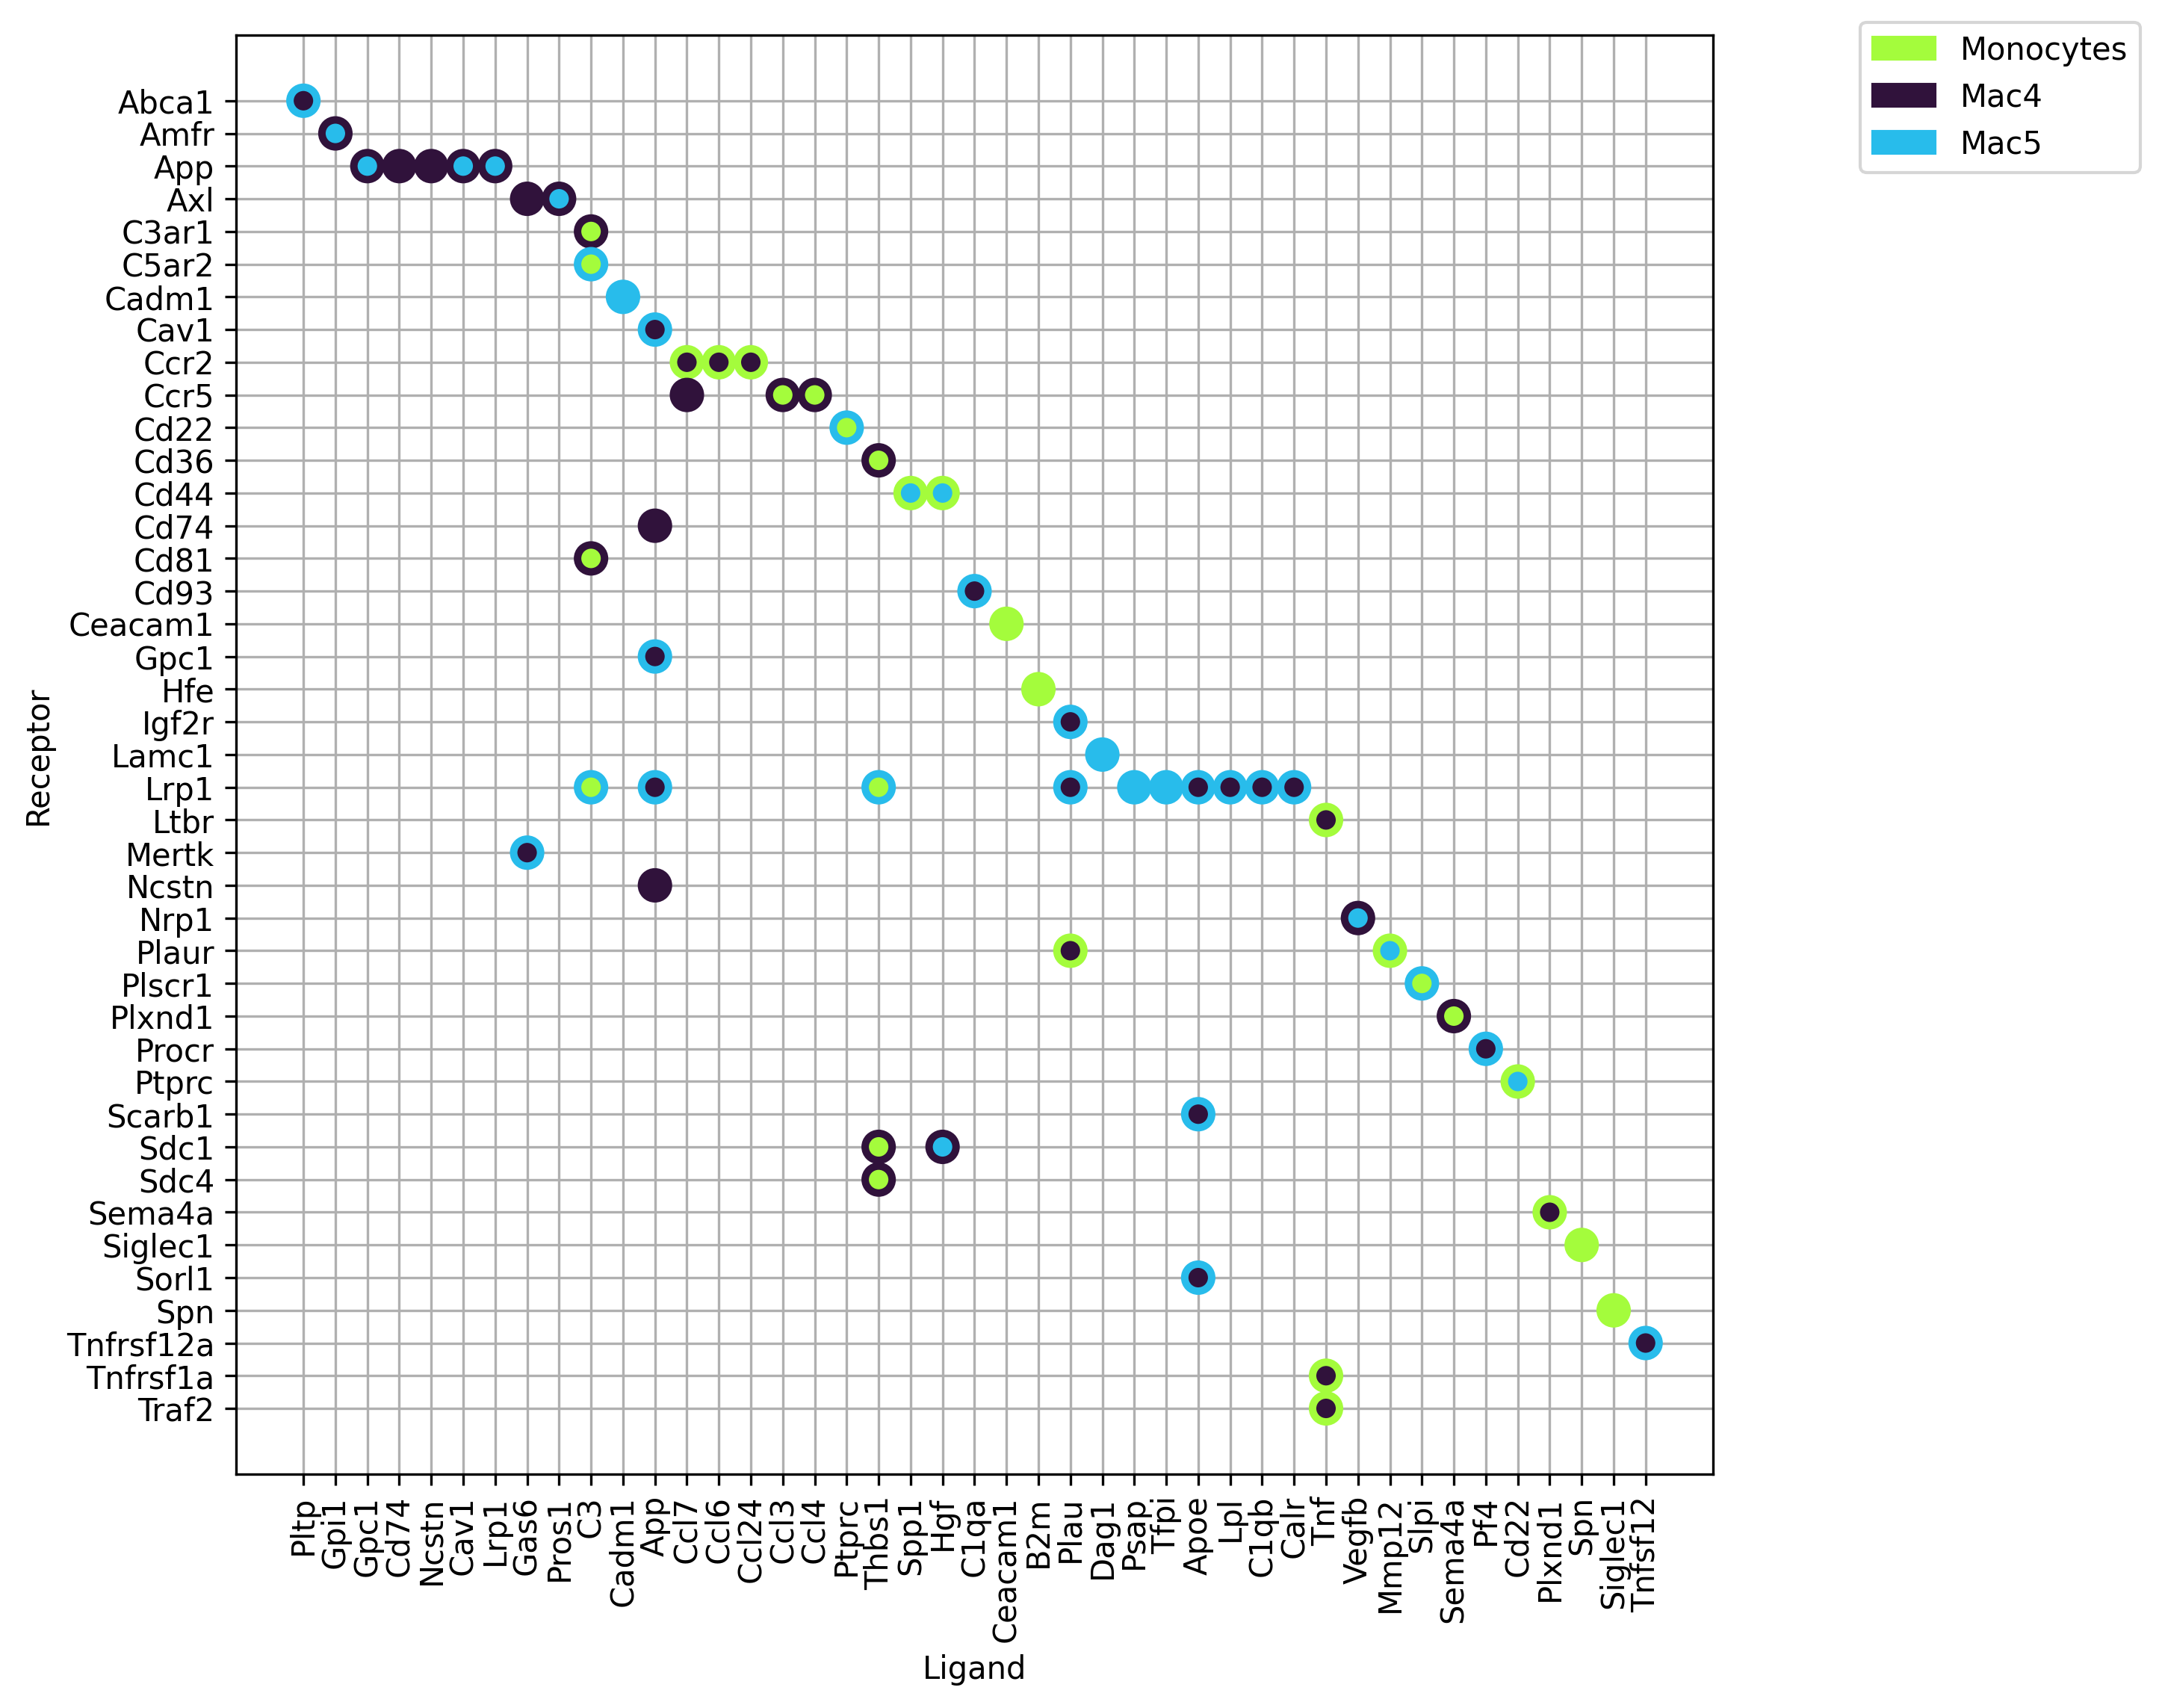

In [22]:
alpha = 0.01
lfc = 0.25

pdf = res.copy()
pdf = pdf[pdf['deg_pval'] < alpha]
pdf = pdf[pdf['log2foldchange'] > lfc]

pdf['LR'] = pdf['ligand'] + "_" + pdf['receptor']
pdf['count'] = pdf.groupby('LR')['type'].transform('nunique')
pdf = pdf[pdf['count'] > 1]
pdf = pdf.sort_values(by=['LR', 'type'])

nf = []

for lrPair in pdf['LR'].unique():
    
    bdf = pdf[pdf['LR'] == lrPair]
    
    row = {
        'ligand' : lrPair.split("_")[0].lower().capitalize(),
        'receptor' : lrPair.split("_")[1].lower().capitalize(),
        'sender' : bdf['cellType'].to_list()[0],
        'reciever' : bdf['cellType'].to_list()[1],
        'coloc' : bdf['LRcolocalization'].to_list()[0],
        'spatialCorr' : bdf['LRcorr'].to_list()[0],
        'ligandCorr' : bdf['corr'].to_list()[0],
        'receptorCorr' : bdf['corr'].to_list()[1],
    }
    
    nf.append(row)
    
nf = pd.DataFrame(nf)

cmap = "turbo"
colorMap = dict(zip(sorted(res['cellType'].unique()), ut.ncolor(5, cmap=cmap)))
nf['sColor'] = nf['sender'].map(colorMap)
nf['rColor'] = nf['reciever'].map(colorMap)
nf = nf.sort_values(by='receptor')


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8.5, 8.5
plt.rcParams['figure.facecolor'] = "w"

sns.scatterplot(data=nf, 
                x='ligand',
                y='receptor',
                ec=nf['rColor'].to_list(),
                c=nf['sColor'].to_list(),
                linewidth=2.4,
                s=75,
                zorder=2)

plt.ylabel("Receptor")
plt.xlabel("Ligand")
ax = plt.gca()
ax.grid(True, zorder=0)
ax.tick_params(axis='x', labelrotation=90)

handles = []

for ctype in ctypes:
    handle = mpatches.Patch(color=colorMap[ctype], 
                            label=ctype)
    handles.append(handle)
    
plt.legend(handles=handles, bbox_to_anchor=(1.3, 1.02))
# pdf


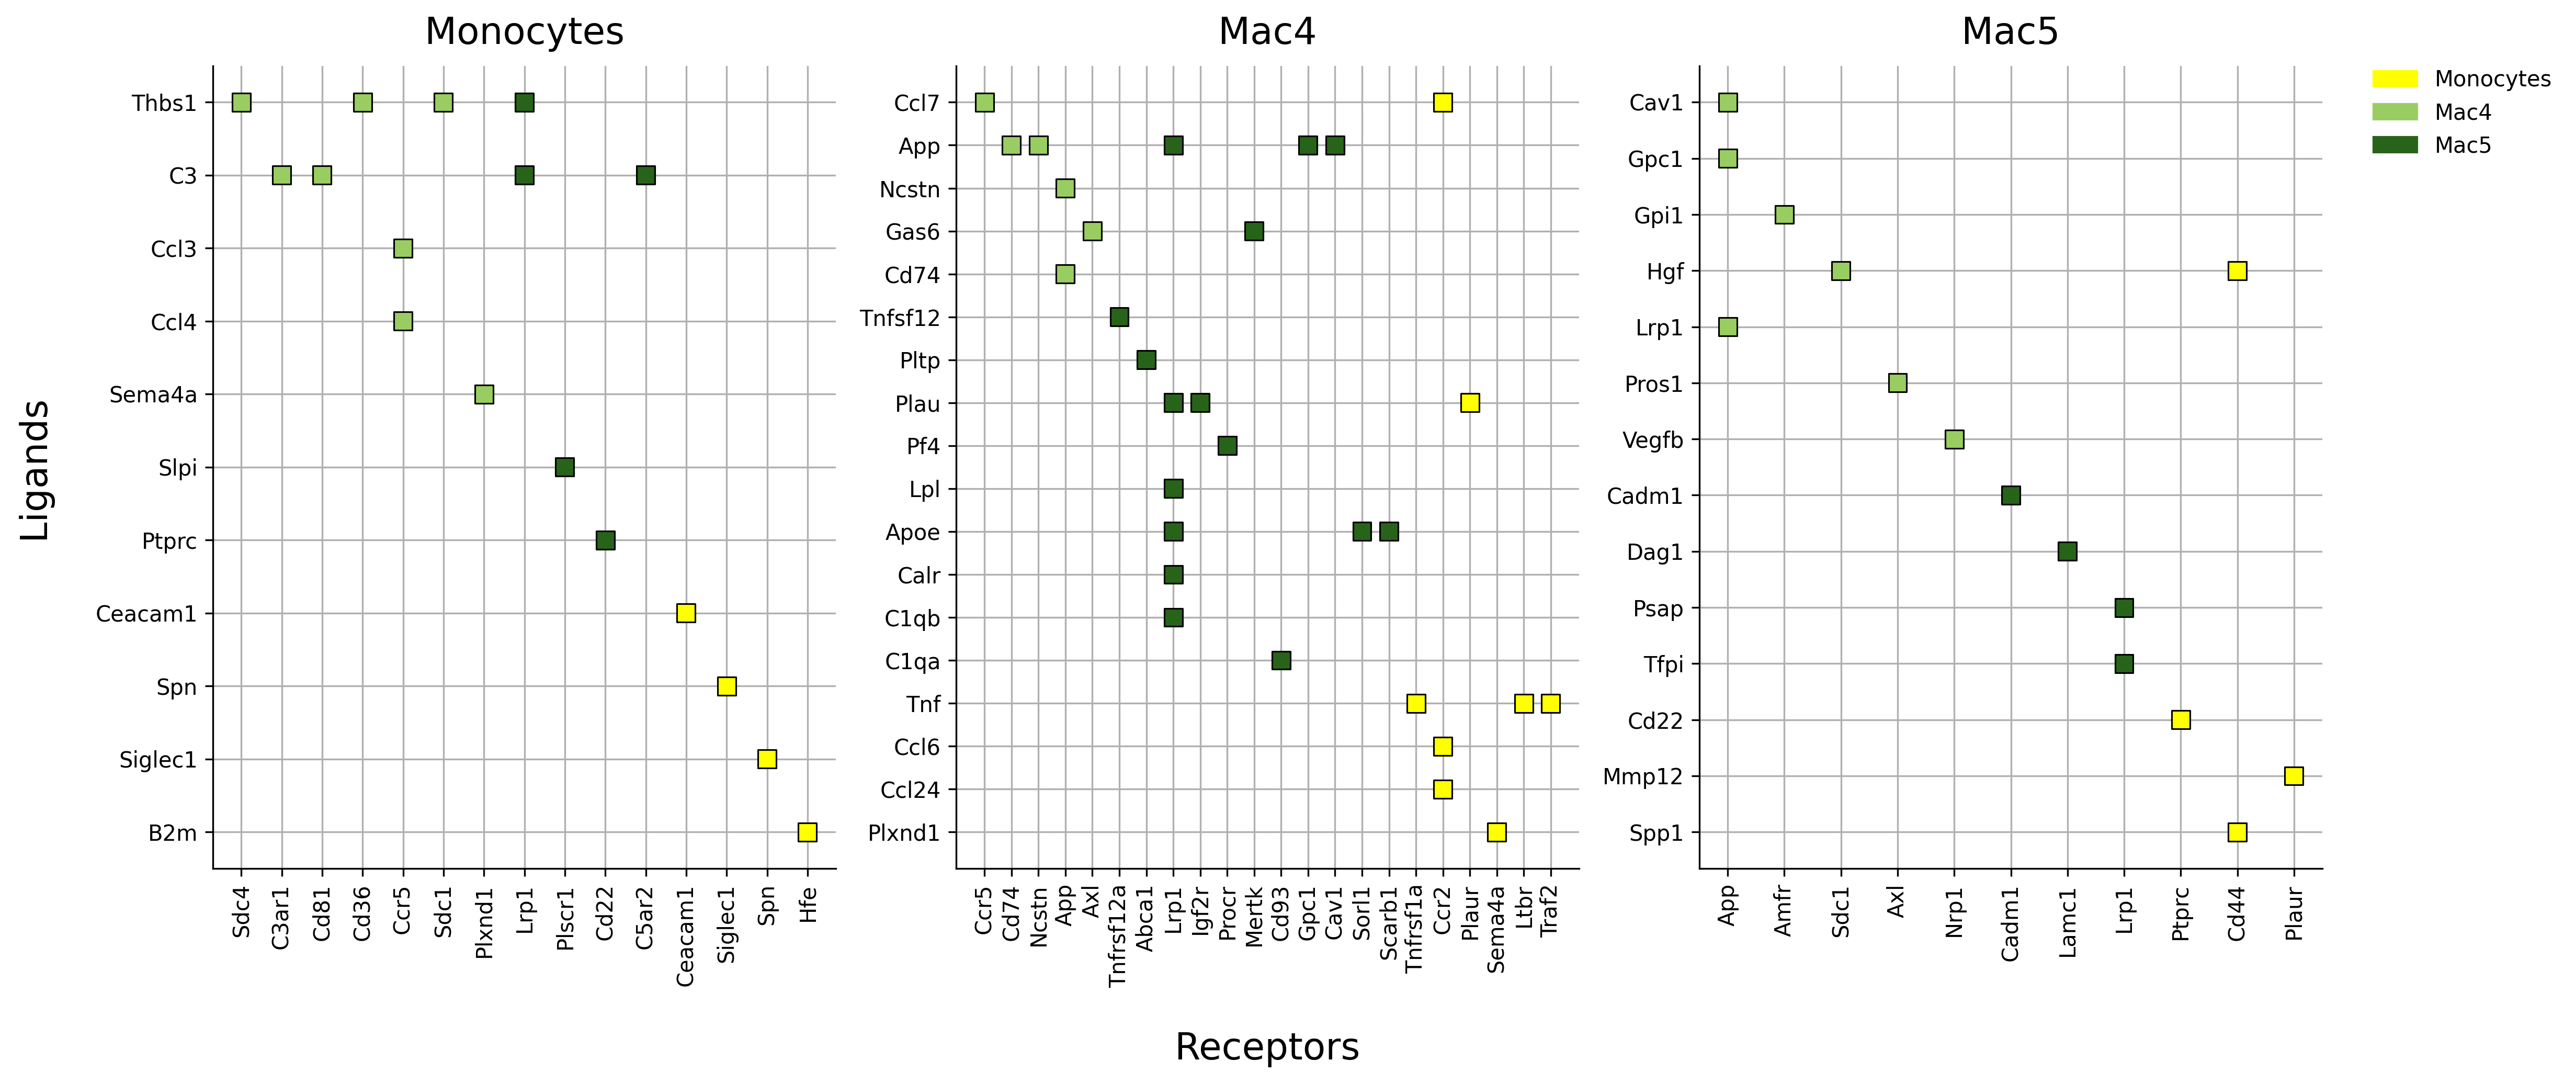

In [38]:
alpha = 0.01
lfc = 0.25

pdf = res.copy()
pdf = pdf[pdf['deg_pval'] < alpha]
pdf = pdf[pdf['log2foldchange'] > lfc]

pdf['LR'] = pdf['ligand'] + "_" + pdf['receptor']
pdf['count'] = pdf.groupby('LR')['type'].transform('nunique')
pdf = pdf[pdf['count'] > 1]
pdf = pdf.sort_values(by=['LR', 'type'])

colorMap = {
    'Monocytes' : 'yellow',
    'Mac4' : '#9acd61',
    'Mac5' : '#276419',
}


nf = []

for lrPair in pdf['LR'].unique():
    
    bdf = pdf[pdf['LR'] == lrPair]
    
    row = {
        'ligand' : lrPair.split("_")[0].lower().capitalize(),
        'receptor' : lrPair.split("_")[1].lower().capitalize(),
        'sender' : bdf['cellType'].to_list()[0],
        'reciever' : bdf['cellType'].to_list()[1],
        'coloc' : bdf['LRcolocalization'].to_list()[0],
        'spatialCorr' : bdf['LRcorr'].to_list()[0],
        'ligandCorr' : bdf['corr'].to_list()[0],
        'receptorCorr' : bdf['corr'].to_list()[1],
    }
    
    nf.append(row)
    
nf = pd.DataFrame(nf)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 7
plt.rcParams['figure.facecolor'] = "None"
fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

nf['sColor'] = nf['sender'].map(colorMap)
nf['rColor'] = nf['reciever'].map(colorMap)

for i, ctype in enumerate(ctypes):
    pdf = nf[nf['sender'] == ctype]
    pdf = pdf.sort_values(by='reciever')
    # print(pdf.head())

    
    sns.scatterplot(data=pdf, 
                    y='ligand',
                    x='receptor',
                    ec='k',
                    marker="s",
                    c=pdf['rColor'].to_list(),
                    linewidth=0.75,
                    # size_norm=(0, 0.1),
                    legend=False,
                    s=70,
                    # size='coloc',
                    ax=axs[i],
                    zorder=2)
    
    axs[i].grid(True, zorder=0)
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_title(ctype, fontsize=17, pad=10)
    axs[i].set_facecolor('None')
    
    if i == 0:
        axs[i].set_ylabel(f"Ligands", labelpad=20, fontsize=17)
    else:
        axs[i].set_ylabel(f"")
        
    if i == 1:
        axs[i].set_xlabel(f"Receptors", labelpad=20, fontsize=17)
    else:
        axs[i].set_xlabel(f"")
    
plt.tight_layout()


handles = []

for ctype in ctypes:
    handle = mpatches.Patch(color=colorMap[ctype], 
                            label=ctype)
    handles.append(handle)

sns.despine()    
plt.legend(handles=handles, 
           frameon=False, 
           bbox_to_anchor=(1.4, 1.02))


In [24]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
pdf = res.copy()
pdf.head()

In [ ]:
alpha = 0.01
lfc = 0.25
colocT = 0.05

pdf = res.copy()
pdf = pdf[pdf['deg_pval'] < alpha]
pdf = pdf[pdf['log2foldchange'] > lfc]
pdf = pdf[pdf['LRcolocalization'] > colocT]

pdf['LR'] = pdf['ligand'] + "_" + pdf['receptor']
pdf['count'] = pdf.groupby('LR')['type'].transform('nunique')
pdf = pdf[pdf['count'] > 1]
pdf = pdf.sort_values(by=['LR', 'type'])

colorMap = {
    'Monocytes' : 'yellow',
    'Mac4' : '#9acd61',
    'Mac5' : '#276419',
}


nf = []

for lrPair in pdf['LR'].unique():
    bdf = pdf[pdf['LR'] == lrPair]
    
    row = {
        'ligand' : lrPair.split("_")[0].lower().capitalize(),
        'receptor' : lrPair.split("_")[1].lower().capitalize(),
        'sender' : bdf['cellType'].to_list()[0],
        'reciever' : bdf['cellType'].to_list()[1],
        'coloc' : bdf['LRcolocalization'].to_list()[0],
        'spatialCorr' : bdf['LRcorr'].to_list()[0],
        'ligandCorr' : bdf['corr'].to_list()[0],
        'receptorCorr' : bdf['corr'].to_list()[1],
    }
    
    nf.append(row)
    
nf = pd.DataFrame(nf)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 7
plt.rcParams['figure.facecolor'] = "None"
fig, axs = plt.subplots(3, 1)
axs = axs.ravel()

nf['sColor'] = nf['sender'].map(colorMap)
nf['rColor'] = nf['reciever'].map(colorMap)

for i, ctype in enumerate(ctypes):
    pdf = nf[nf['sender'] == ctype]
    pdf = pdf.sort_values(by='reciever')
    # print(pdf.head())

    
    sns.scatterplot(data=pdf, 
                    y='ligand',
                    x='receptor',
                    ec='k',
                    c=pdf['rColor'].to_list(),
                    linewidth=0.75,
                    # size_norm=(0, 0.1),
                    legend=False,
                    s=70,
                    # size='coloc',
                    ax=axs[i],
                    zorder=2)
    
    axs[i].grid(True, zorder=0)
    axs[i].tick_params(axis='x', labelrotation=90)

    # axs[i].set_title(ctype)
    axs[i].set_ylabel(f"")
    axs[i].set_xlabel(f"")
    
plt.tight_layout()


handles = []

for ctype in ctypes:
    handle = mpatches.Patch(color=colorMap[ctype], 
                            label=ctype)
    handles.append(handle)
    
plt.legend(handles=handles, bbox_to_anchor=(1.7, 1.02))


In [ ]:
break

In [ ]:

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15.5, 15
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(3, 2)

top = 20

for i, ctype in enumerate(ctypes):
    for j, geneType in enumerate(['ligand', 'receptor']):

        mask = (res['cellType'] == ctype) & (res['type'] == geneType)
        pdf = res[mask]
        pdf = pdf.sort_values(by='corr', ascending=False)
        pdf['ligand'] = pdf['ligand'].apply(lambda x: str(x).lower().capitalize())
        pdf['receptor'] = pdf['receptor'].apply(lambda x: str(x).lower().capitalize())
        
        print(pdf.head())
        
        
        break
        
#         sns.scatterplot(data=pdf.head(top), 
#                 x='receptor',
#                 y='ligand',
#                 size='LRcolocalization',
#                 hue='corr',
#                 palette='inferno',
#                 zorder=10,
#                 # hue_norm=(0, 1),
#                 legend=False,
#                 ec='k',
#                 ax=axs[i, j])
        
#         axs[i, j].set_ylabel(f"Ligands")
#         axs[i, j].set_xlabel(f"Receptors")
#         axs[i, j].tick_params(axis='x', labelrotation=90)
#         axs[i, j ].grid(True, zorder=0)
#         axs[i, j].set_title(f"{ctype} {geneType.capitalize()}s")
        

    break

    
plt.tight_layout()

In [ ]:
?ut.makeColorbar

In [ ]:
ut.makeColorbar(cmap='inferno', 
                 width=0.3,
                 hieght=2.5,
                 title="Spatial Correlation", 
                 orientation='vertical',
                 tickLabels=['Low', 'High'])

In [ ]:
break

In [ ]:
np.all(sdf.index == cardDf['spotId'])

In [ ]:
cardDf.head()

In [ ]:
break

In [ ]:
"""
GLOBAL DEG
"""
res = []

for 

# for gene in expLR:
    
#           for lrp in lrPairs:
#             score, pval = scipy.stats.ranksums(inNet[lrp], 
#                                                outNet[lrp],
#                                                alternative='two-sided')
            
#             lfc = np.log2(inNet[lrp].mean()+1) - np.log2(outNet[lrp].mean()+1)
                   
    